In [1]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import collections
import random
import time
pd.set_option('display.max_colwidth', None)

Get info of all metrics implemented

In [2]:
metrics = []
try:
    request = requests.get('http://seprojects.marum.de:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('marvel2020', 'wonderwoman2020'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [4]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2
5,FsF-A1-01M,Metadata contains access level and access conditions of the data.,1
6,FsF-A1-02MD,Metadata as well as data are retrievable by their identifier using a standardized communications protocol.,2
7,FsF-A2-01M,"Metadata remains available, even if the data is no longer available.",1
8,FsF-I1-01M,Metadata is represented using a formal knowledge representation language.,2
9,FsF-I1-02M,Metadata uses semantic resources,1


In [ ]:
# F1 -> 2, F2->2, F3-> 1, F4->2

In [ ]:
F1 -> 2, F2->1, F3-> 0, F4->2

Run FAIR assessment for a given identifier

In [182]:
identifier = 'https://doi.org/10.1594/PANGAEA.902843'

In [183]:
%%time
fuji_service = 'http://seprojects.marum.de:1071/fuji/api/v1/evaluate'
req = {'object_identifier':identifier, 'test_debug':True}
r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('marvel2020', 'wonderwoman2020'))
json_data = r.json()

CPU times: user 9.4 ms, sys: 4.36 ms, total: 13.8 ms
Wall time: 4.51 s


In [184]:
json_data

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned a globally unique identifier.',
  'output': {'guid': 'https://doi.org/10.1594/PANGAEA.902843',
   'guid_scheme': 'doi'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['doi', 'url']",
   'INFO: Finalized unique identifier scheme - doi'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned a persistent identifier.',
  'output': {'pid': 'https://doi.org/10.1594/PANGAEA.902843',
   'pid_scheme': 'doi',
   'resolvable_status': True,
   'resolved_url': 'https://doi.pangaea.de/10.1594/PANGAEA.902843'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - doi',
   'INFO: Retrieving page http://doi.org/10.1594/PANGAEA.902843',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: Object identifier act

In [185]:
results = {}
results['identifier'] = identifier
for d in json_data:
    metric_identifier = d['metric_identifier']
    sub_principle = metric_identifier.split('-')[1]
    principle = sub_principle[0]+'_earned'
    principle_total = sub_principle[0]+'_total'
    if not sub_principle in results:
        results[sub_principle] = d['score']['earned']
    else:
        results[sub_principle] += d['score']['earned']
    if not principle in results:
        results[principle] = d['score']['earned']
    else:
        results[principle] += d['score']['earned']
    if not principle_total in results:
        results[principle_total] = d['score']['total']
    else:
        results[principle_total] += d['score']['total']

In [186]:
results

{'identifier': 'https://doi.org/10.1594/PANGAEA.902843',
 'F1': 2,
 'F_earned': 7,
 'F_total': 7,
 'F2': 2,
 'F3': 1,
 'F4': 2,
 'A1': 1,
 'A_earned': 1,
 'A_total': 1,
 'I1': 2,
 'I_earned': 3,
 'I_total': 4,
 'I3': 1,
 'R1': 3,
 'R_earned': 7,
 'R_total': 9,
 'R1.1': 1,
 'R1.2': 1,
 'R1.3': 2}

In [187]:
#############################################
# functions processing 'results' dictionary data,
# preparing this data for pie chart plot
#############################################

def get_main_dict(results, main_keys):
    '''
    DECSRIPTION
        creates main_dict - dictionary, with several 1st level keys F,A,I,R 
        value of each key is a dictionary itself, containing corresponding 2nd level elements e.g. F1,F2 for F
    INPUT
        results dictionary,containing processed json data about dataset metrics
        main_keys - list, contatining main metrics names e.g. ['F','A','I','R']
    OUTPUT
        main_dict 
    '''
    main_dict={}
    for main_key in main_keys:
        dummy_dict={}
        for key in results.keys():
            # filter out the keys relating to main_keys 
            if main_key in key:
                dummy_dict[key]=results[key]
                # dummy_list.append({key:results[key]})
        main_dict[main_key]=dummy_dict
    
    return main_dict

def pop_earned_total(main_dict):
    '''
    DESCRIPTION
        If there is a difference between 'earned' 'total' values (F_total,F earned)
        replace 'earned' 'total' entries with difference between them - F_diff.
        Otherwise just pop the 'earned' 'total' entries.
    INPUT
        main_dict - dictionary
    OUPUT 
        modified main_dict (without earned, total entries)
    '''
    for main_key in main_dict.keys():
        
        earned_points=main_dict[main_key][main_key+'_earned']
        total_points=main_dict[main_key][main_key+'_total']
        points_difference=total_points-earned_points
            
        if points_difference!=0:
            main_dict[main_key][main_key+'_diff']=total_points-earned_points
            
        # pop the total,earned entries 
        main_dict[main_key].pop(main_key+'_earned')
        main_dict[main_key].pop(main_key+'_total')
    
    return main_dict

def get_plot_data(main_dict):
    '''
    DECSRIPTION
        creates an input array for pie chart plot function
    INPUT
        main_dict - dictionary, with several 1st level keys F,A,I,R 
        value of each key is a dictionary itself, containing corresponding 2nd level elements e.g. F1,F2 for F
    OUTPUT
        dictionary containing 4 arrays(lists) necessary for pie chart plot

        fl_labels - list of 1st level labels e.g  ['F', 'A', 'I', 'R']
        fl_arr - array of corresponding values

        sl_labels - list of 2nd level labels e.g ['F1', 'F_earned', 'F_total', 'A1', 'A_earned', 'A_total', 'I1]
        sl_arr - array of corresponding values
    '''
    
    # list of values to for every main key 
    # e.g. [[2, 7, 7, 2, 1, 2], [1, 1, 1]]
    vals=[]
    # list of corresponding labels
    # e.g. [['F1', 'F_earned', 'F_total', 'F2', 'F3', 'F4'],['A1', 'A_earned', 'A_total']]
    labels=[]
    
    # main keys - keys of main_dict dictionary e.g. F,A,I,R
    for main_key in main_dict.keys():
        # e.g. F -> [2, 7, 7, 2, 1, 2]
        groupped_vals=list(main_dict[main_key].values())
        # e.g. F -> ['F1', 'F_earned', 'F_total', 'F2', 'F3', 'F4']
        groupped_labels=list(main_dict[main_key].keys())
        vals.append(groupped_vals)
        labels.append(groupped_labels)

    # array 1st level elements and corresponding labels - e.g. F,A,I,R
    fl_arr=np.array([sum(list_i) for list_i in vals])
    fl_labels=list(main_dict.keys())

    # array of 2nd level elements (more detailed) and corresponding labels - e.g. F1,F2
    sl_arr=np.array([j for i in vals for j in i])
    sl_labels=list([j for i in labels for j in i])
    
    # pack output array/lists in a dictionary
    data_to_plot={'fl_arr':fl_arr,'fl_labels':fl_labels,'sl_arr':sl_arr,'sl_labels':sl_labels}
    
    return data_to_plot

In [188]:
def color_generator(colormap,main_dict,col_index1,col_index2):
    '''
     DESCRIPTION
         generate colors for inner (F1,F2,I1,R1,..) and outer ring (F,A,I,R) of pie chart 
     INPUT
         main_dict - dictionary, with several 1st level keys F,A,I,R value 
                     of each key is a dictionary itself, containing corresponding 2nd level elements 
         col_index1 (integer) - defines the width of outer ring colorband
         col_index2 (integer) - measure of relation between inner and outer rings 
                      color schemes. When equal 0, both rings have the same colors
     OUTPUT
         colors - dictionary with mapped colors 
    '''
    
    #get number of nececessary colors corresponding to 
    # number of 2nd level elements (F1,F2,..) for every 1st level element (F)
    ncolors=[]
    for main_key in main_dict.keys():
        ncolors.append(len(main_dict[main_key].values()))
    
    # generate outer colors 
    n_outer_colors=len(main_dict.values())
    cmap = plt.get_cmap(colormap)
    outer_colors=np.arange(1,n_outer_colors+1)*col_index1
    
    # generate inner colors based on 
    # outer colors 
    inner_colors=[]
    for i in range(len(outer_colors)):
        color_arr=np.arange(ncolors[i])*col_index2+outer_colors[i]
        inner_colors.append(color_arr)
        
    inner_arr=np.concatenate(inner_colors)  
    colors={'outer':cmap(outer_colors),'inner':cmap(inner_arr)}
    
    return colors

In [203]:
###############
# Main function
###############

def metrics_pie_plot(results, main_keys):
    '''
    DECSRIPTION
        processes input data, then plots the pie chart for FAIR metrics
    INPUT
        results dictionary,containing processed json data (dataset metrics)
        main_keys - list, contatining main metrics names e.g. ['F','A','I','R']
    OUTPUT
        ax - matplotlib.axes._subplots.AxesSubplot object 
    '''
    #INPUT DATA PROCESSING
    # get a dictionary with a key for each 1st level metric F,A,I,R
    # e.g. {'A': {'A1': 1, 'A_earned': 1, 'A_total': 1},{I:..}}
    main_dict=get_main_dict(results, main_keys)
    # replace 'earned' 'total' entries with difference between them - F_diff
    main_dict=pop_earned_total(main_dict)
    # get dictionary of input arrays for pie plot function
    data_to_plot=get_plot_data(main_dict)
    # generate colors for inner (F1,F2,I1,R1,..) and outer ring (F,A,I,R) of pie chart
    colors=color_generator('plasma',main_dict,50,10)

    #PLOTTING
    fig, ax = plt.subplots(figsize=(9,9))
    size = 0.3

    #OUTER RING
    patches, texts=ax.pie(data_to_plot['fl_arr'], radius=1, colors=colors['outer'],labels=data_to_plot['fl_labels'],
          labeldistance=0.9, wedgeprops=dict(width=size, edgecolor='w'),counterclock=False,startangle=90)
    # add legend
    plt.legend(patches, data_to_plot['fl_labels'], loc="best")
    # increase the size of the labels
    [text.set_fontsize(18) for text in texts]

    # INNER RING
    ax.pie(data_to_plot['sl_arr'], radius=1-size, colors=colors['inner'],labels=data_to_plot['sl_labels'],
           labeldistance=0.7,wedgeprops=dict(width=size, edgecolor='w'),counterclock=False,
           startangle=90,rotatelabels=True)

    return ax

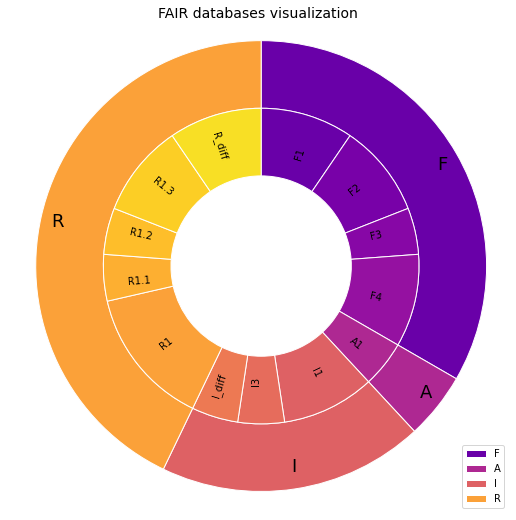

In [211]:
metrics_pie_plot(results, main_keys=['F','A','I','R'])
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()

Lets change results dictionary -throw away R metrics and then try to plot pie chart again.

In [193]:
results

{'identifier': 'https://doi.org/10.1594/PANGAEA.902843',
 'F1': 2,
 'F_earned': 7,
 'F_total': 7,
 'F2': 2,
 'F3': 1,
 'F4': 2,
 'A1': 1,
 'A_earned': 1,
 'A_total': 1,
 'I1': 2,
 'I_earned': 3,
 'I_total': 4,
 'I3': 1,
 'R1': 3,
 'R_earned': 7,
 'R_total': 9,
 'R1.1': 1,
 'R1.2': 1,
 'R1.3': 2}

In [205]:
results_modified={'identifier': 'https://doi.org/10.1594/PANGAEA.902843',
 'F1': 2,
 'F_earned': 7,
 'F_total': 7,
 'F2': 2,
 'F3': 1,
 'F4':2,                
 'A1': 1,
 'A_earned': 1,
 'A_total': 1,
 'I1': 2,
 'I_earned': 3,
 'I_total': 4,
 'I3': 1}

Now we will call only three main_keys as there are no R metric in results_modified

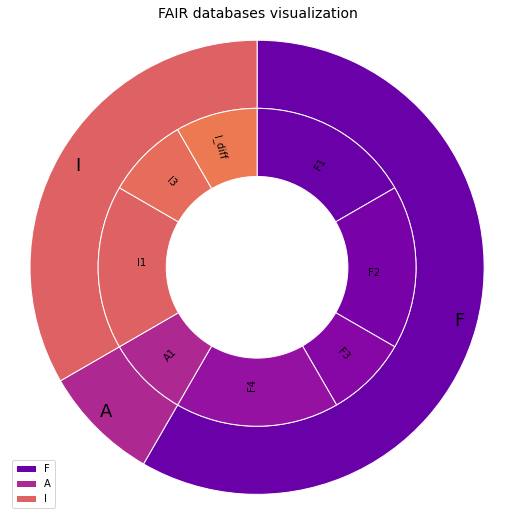

In [206]:
metrics_pie_plot(results_modified, main_keys=['F','A','I'])
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()

Lets put an additional X metric into results dictionary and then plot the pie chart.

In [207]:
results_modified={'identifier': 'https://doi.org/10.1594/PANGAEA.902843',
 'F1': 2,
 'F_earned': 7,
 'F_total': 7,
 'F2': 2,
 'F3': 1,
 'F4':2,                
 'A1': 1,
 'A_earned': 1,
 'A_total': 1,
 'I1': 2,
 'I_earned': 3,
 'I_total': 4,
 'I3': 1,
  'R1': 3,
 'R_earned': 7,
 'R_total': 9,
 'R1.1': 1,
 'R1.2': 1,
 'R1.3': 2,
 'X1': 3,
 'X_earned': 7,
 'X_total': 9,
 'X1.1': 1,
 'X1.2': 1,
 'X1.3': 2}

Now we will add 5th main_key -X

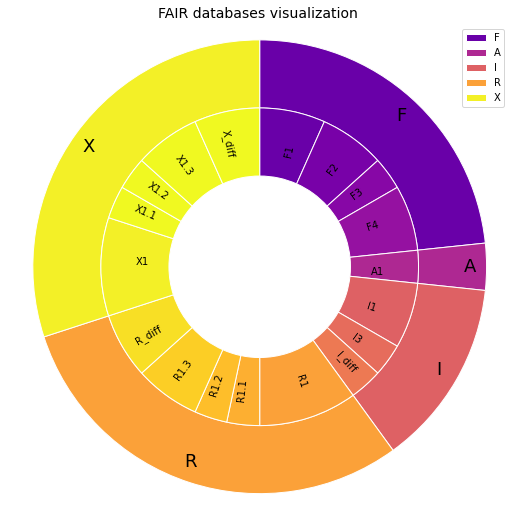

In [208]:
metrics_pie_plot(results_modified, main_keys=['F','A','I','R','X'])
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()